In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.4.1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Riya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [3]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)

In [4]:
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


Text(0.5, 1.0, 'Spam/ham Data Distribution')

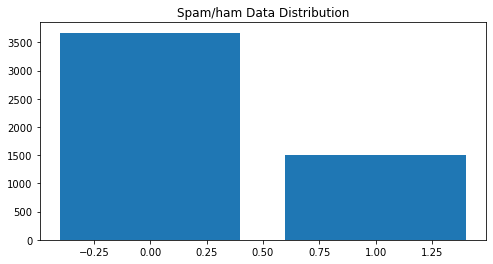

In [5]:
val_count = data.label_num.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Spam/ham Data Distribution")

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|Subject:|subject|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
data.text = data.text.apply(lambda x: preprocess(x))

In [13]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.Collecting wordcloud



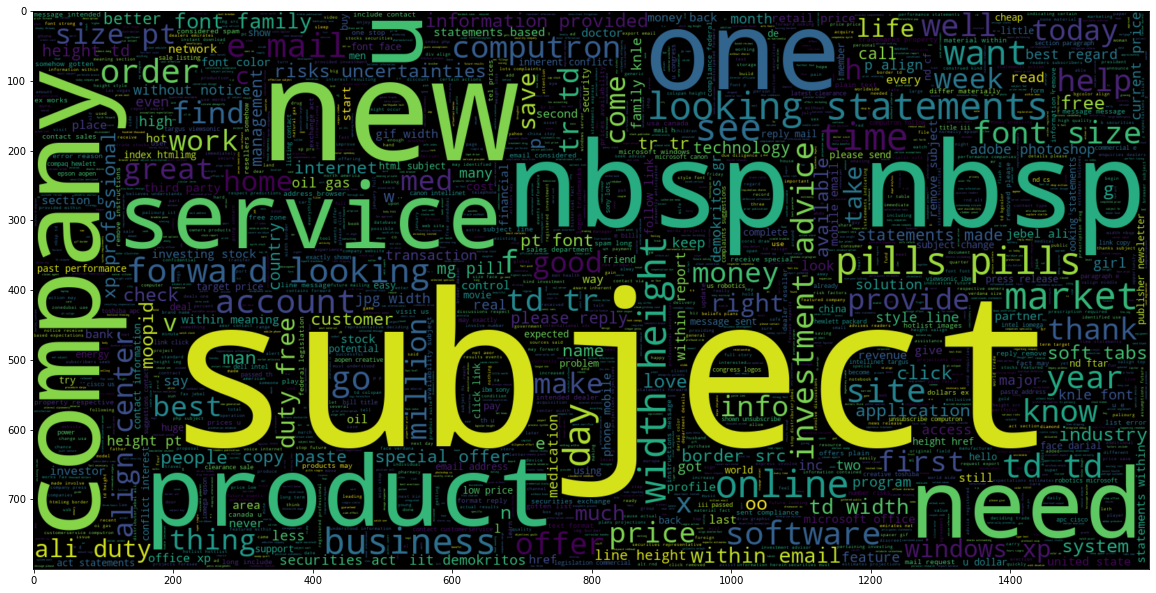

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label_num == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

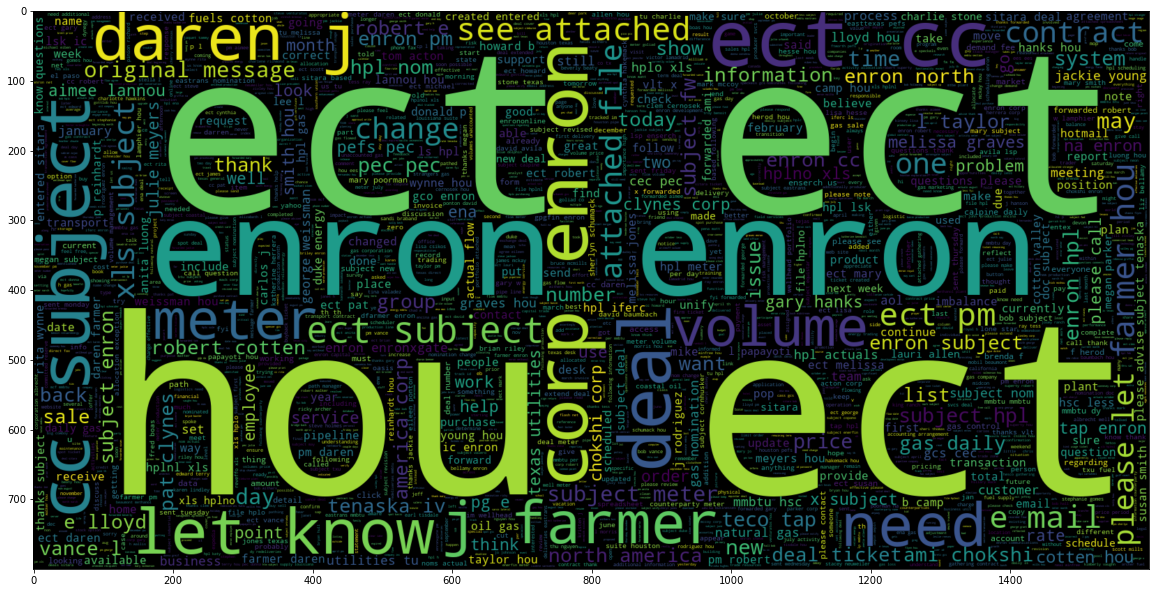

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label_num == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [21]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

In [22]:
train_data, test_data = train_test_split(data, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 4136
Test Data size 1035


In [23]:
train_data.head(10)

,text,label_num
362,subject hpl nom january 5 2001 see attached fi...,0
1078,subject enron hpl actuals november 1 2000 teco...,0
2421,subject ponderosa pine energy partners ltd gas...,0
2331,subject final cp name change merger list 08 00...,0
2004,subject enron hpl actuals october 10 2000 teco...,0
4980,subject meter 98 9699 98 2662 receipt meters w...,0
1032,subject fwd hi paliourg like watch real people...,1
2039,subject cp l daren handling cp l trying resolv...,0
3412,subject please print forwarded message scott f...,0
662,subject meter 5892 need help john childres alp...,0


## TOKENIZER

In [44]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 43796


In [45]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4136, 50)
Testing X Shape: (1035, 50)


## LSTM

In [59]:
#LSTM hyperparameters
n_lstm = 200
drop_lstm =0.2

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [61]:
#vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24
num_epochs = 30
#early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [62]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='relu'))

In [63]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [64]:
num_epochs = 30
#early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(x_train, train_data.label_num, epochs=num_epochs, validation_data=(x_test, test_data.label_num), verbose=2)

Epoch 1/30
130/130 - 40s - loss: 0.5354 - accuracy: 0.7433 - val_loss: 0.3364 - val_accuracy: 0.8366
Epoch 2/30
130/130 - 25s - loss: 0.2455 - accuracy: 0.8882 - val_loss: 0.3475 - val_accuracy: 0.8786
Epoch 3/30
130/130 - 19s - loss: 0.1862 - accuracy: 0.9141 - val_loss: 0.3425 - val_accuracy: 0.8846
Epoch 4/30
130/130 - 20s - loss: 0.1700 - accuracy: 0.9200 - val_loss: 0.3527 - val_accuracy: 0.8883
Epoch 5/30
130/130 - 19s - loss: 0.1808 - accuracy: 0.9131 - val_loss: 0.3050 - val_accuracy: 0.8403
Epoch 6/30
130/130 - 20s - loss: 0.1709 - accuracy: 0.9188 - val_loss: 0.3739 - val_accuracy: 0.8934
Epoch 7/30
130/130 - 20s - loss: 0.1536 - accuracy: 0.9271 - val_loss: 0.3732 - val_accuracy: 0.8945
Epoch 8/30
130/130 - 27s - loss: 0.1514 - accuracy: 0.9289 - val_loss: 0.4206 - val_accuracy: 0.8935
Epoch 9/30
130/130 - 31s - loss: 0.1519 - accuracy: 0.9286 - val_loss: 0.4518 - val_accuracy: 0.8917
Epoch 10/30
130/130 - 30s - loss: 0.1486 - accuracy: 0.9305 - val_loss: 0.5325 - val_accura

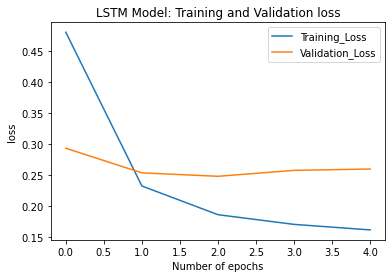

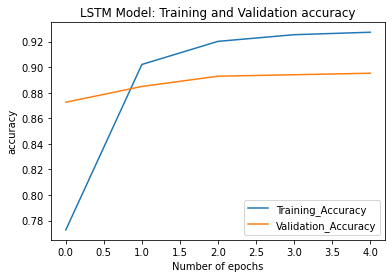

In [52]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [66]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [67]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [69]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(x_train, train_data.label_num, epochs=num_epochs, 
                    validation_data=(x_test, test_data.label_num),callbacks =[early_stop], verbose=2)

Epoch 1/30
130/130 - 61s - loss: 0.3185 - accuracy: 0.8574 - val_loss: 0.1368 - val_accuracy: 0.9537
Epoch 2/30
130/130 - 25s - loss: 0.0514 - accuracy: 0.9879 - val_loss: 0.0880 - val_accuracy: 0.9742
Epoch 3/30
130/130 - 21s - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.1012 - val_accuracy: 0.9737
Epoch 4/30
130/130 - 21s - loss: 0.0155 - accuracy: 0.9976 - val_loss: 0.1541 - val_accuracy: 0.9730


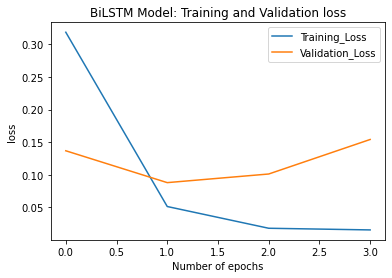

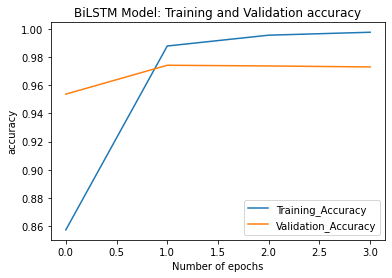

In [70]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [3]:
from tensorflow.keras.models import load_model

#model2.save('bilstm.h5')

In [6]:
model = load_model('bilstm.h5')
pred= model.predict("Subject: hpl nom for january 9 , 2001( see attached file : hplnol 09 . xls )- hplnol 09 . xls")

IndexError: list index out of range